In [9]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
import pickle

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from scipy.stats import spearmanr, ttest_1samp, binned_statistic
from settings import (colors, titles, ax_label_size, tick_label_size,
                      letter_size, legend_size, lw, line_alpha, fill_alpha)
from settings import (plot_lower, plot_upper, stats_frac_lower,
                      stats_frac_upper, select_lower, select_upper,
                      p_lower, p_upper, stats_frac_middle,
                      ci, title_pad)

In [10]:
ccycle = mplego.colors.get_default_ccycle()

In [11]:
exp = 10
base_path = f"/storage/noise_correlations/exp{exp}"
loc = 'data'
loc = 'noise_correlations'

In [12]:
ret2_path = os.path.join(base_path, f'exp{exp}_ret2_20_1000_1000.h5')
pvc11_1_path = os.path.join(base_path, f'exp{exp}_1_pvc11_20_1000_1000.h5')
ecog_path = os.path.join(base_path, f'exp{exp}_ecog_20_3000_1000.h5')
roi_path = os.path.join(f"/storage/{loc}/ret2/roi_positions.mat")

In [13]:
ret2 = h5py.File(ret2_path, 'r')
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ecog = h5py.File(ecog_path, 'r')
results = [ret2, pvc11_1, ecog]

In [14]:
n_max_units = pvc11_1['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)
n_results = len(results)

In [17]:
groups = [
    'v_lfi',
    'v_s_lfi',
    'v_u_lfi',
    'v_fa_lfi'
]
labels = [
    'UC',
    'FA'
]
percentile_groups = [
    'p_u_lfi',
    'p_fa_lfi'
]
models = [
    'uniform',
    'fa'
]

In [18]:
def peak_width(ps):
    ps = np.atleast_2d(ps)
    ps = np.sort(ps, axis=1)[:, ::-1]
    ranks = np.linspace(0, 1, ps.shape[1])[np.newaxis][:, ::-1]
    widths =  np.maximum(1, np.argmin(ps >= ranks, axis=1)) / ps.shape[1]
    widths[ps[:, 0] < 1.] = 0.
    return np.squeeze(widths)

In [19]:
widths = dict()
for idx, result in enumerate(results):
    # Iterate over null models
    for group in percentile_groups:
        percentiles = result[group][:]
        widths[(idx, group)] = utils.run_bootstrap(percentiles, peak_width, ci)

0.04000000000000001 0.96
0.3083333333333334 0.96
0.5766666666666667 0.96
0.04000000000000001 0.7162499999999999
0.3083333333333334 0.7162499999999999
0.5766666666666667 0.7162499999999999
0.04000000000000001 0.4725
0.3083333333333334 0.4725
0.5766666666666667 0.4725
0.04000000000000001 0.22875
0.3083333333333334 0.22875
0.5766666666666667 0.22875


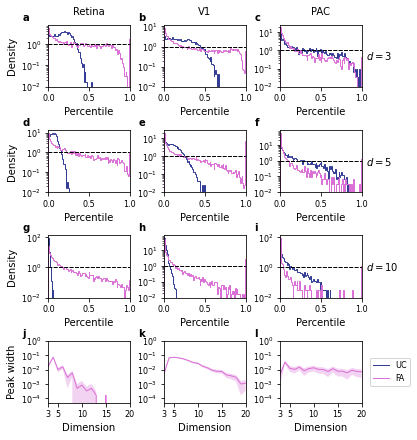

In [20]:
fig = plt.figure(figsize=(6, 6))

le = .1
re = .175
be = .075
te = .05
hg = .08
vg = .1
h = (1. - te - be - 3*vg) / 4.
w = (1. - le - re - 2*hg) / 3.
axes = np.empty((4, 3), dtype=object)
for ii in range(4):
    for jj in range(3):
        axes[ii, jj] = fig.add_axes([le + jj*(w + hg),
                                     be + (3-ii)*(h + vg),
                                     w, h])

# Label adjustments
subplot_x = -0.18
subplot_y = 1.12
# Line settings
# Fill settings
fill_alpha = 0.3
# Legend settings
handlelength = 0.3
handletextpad = 0.3
bins = np.linspace(0, 1, 100)
ds = [3, 5, 10]

# Enumerate over results
for idx, result in enumerate(results):
    # Iterate over null models
    for group, model, label in zip(percentile_groups, models, labels):
        # Calculate median and bounds for each null model

        width = widths[(idx, group)]
        axes[-1, idx].plot(
            dims,
            width[:, 1],
            linewidth=lw,
            color=colors[model],
            label=label)
        axes[-1, idx].fill_between(
        x=dims,
        y1=width[:, 0],
        y2=width[:, 2],
        color=colors[model],
        alpha=fill_alpha,
        ec='none')
        
        percentiles = result[group][:]
        for ii, d in enumerate(ds):
            axes[ii, idx].hist(percentiles[d - 3],
                               bins=bins,
                               color=colors[model],
                               histtype='step',
                               linewidth=lw,
                               density=True)
            axes[ii, idx].axhline(1. / (bins[-1] - bins[0]), 0, 1,
                                 lw=lw, ls='--', c='k')


for idx, ax in enumerate(axes[:3].ravel()):
    ax.set_yscale('log')
    ax.set_ylim(1e-2, None)
    ax.set_xlabel('Percentile', fontsize=ax_label_size)
    ax.set_xlim(bins[0], bins[-1])
for ax in axes[:3, 0]:
    ax.set_ylabel('Density', fontsize=ax_label_size)
for idx, ax in enumerate(axes[0]):
    ax.set_title(titles[idx], fontsize=ax_label_size, pad=title_pad)

for idx, ax in enumerate(axes[-1].ravel()):
    ax.set_ylim([5e-5, 1.])
    ax.set_yscale('log')
    ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1])
    ax.set_xlim([3, 20])
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.set_xlabel('Dimension', fontsize=ax_label_size)
axes[-1, 0].set_ylabel('Peak width', fontsize=ax_label_size)
axes[-1, 2].legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    prop={'size': legend_size})
for ax in axes.ravel():
    ax.tick_params(labelsize=tick_label_size)

for ii, d in enumerate(ds):
    fig.text(le + 2*hg + 3*w + .01,
             1. - te - ii*(h + vg) - h/2,
             r'$d={}$'.format(d),
             va='center',
             ha='left',
             fontsize=ax_label_size)

lets = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']
c = 0
for y in [1. - te - jj*(vg + h) + .01 for jj in range(4)]:
    for ii, x in enumerate([le + ii*(w + hg) - .06 for ii in range(3)]):
        print(x, y)
        fig.text(x, y, lets[c], size=letter_size, fontweight='bold')
        c += 1

plt.savefig('supp5.pdf', dpi=300)
plt.savefig('supp5.jpg', dpi=300)